In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import os
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dirlist = os.listdir('./extracted')[:1000]

In [3]:
path_size = 5
def read_prepared_data():
    X = pd.DataFrame()
    y = pd.DataFrame()
    for i,dirname in enumerate(dirlist):
        X_one_image = pd.read_csv('./extracted/'+dirname+'/stacking_data_wsolid.csv')
        X_one_image = X_one_image.iloc[range(0,X_one_image.shape[0],2)]
        y_one_image = pd.read_csv('./extracted/'+dirname+'/stacking_gt_wsolid.csv')
        y_one_image = y_one_image.iloc[range(0,y_one_image.shape[0],2)]
        X = pd.concat([X,X_one_image],ignore_index=True)  
        y = pd.concat([y,y_one_image],ignore_index=True)
        print(i,dirname,X.shape[0])
    return X,y

In [4]:
feature_list = ['GHS','LK','LLF1','LLF2','LPSS','LST']
label_mark = 'GT'

In [5]:
def read_im_data(dirname,size):
    offset = int((21-int(size))/2)
    size = str(size)
    one_image_data = pd.DataFrame(data=None,columns=feature_list)
    for feature_name in feature_list:
        feature_data = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+feature_name+'.csv',header=-1)
        feature_size = (feature_data.values.shape[0]-offset*2)*(feature_data.values.shape[1]-offset*2)
        if offset!=0:
            one_image_data[feature_name] = list(map(lambda x: x[0],feature_data.values[offset:-offset,offset:-offset].reshape(feature_size,1)))
        else:
            one_image_data[feature_name] = list(map(lambda x: x[0],feature_data.values.reshape(feature_size,1)))
    one_image_labels = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+label_mark+'.csv',header=-1)
    im_size = one_image_labels.shape
    im_size = (im_size[0] - offset*2,im_size[1] - offset*2)
    if offset!=0:
        one_image_labels = list(map(lambda x: x[0],one_image_labels.values[offset:-offset,offset:-offset].reshape(feature_size,1)))
    else:
        one_image_labels = list(map(lambda x: x[0],one_image_labels.values.reshape(feature_size,1)))
    one_image_labels = pd.DataFrame(data=one_image_labels,columns=[label_mark])
    return one_image_data,one_image_labels,im_size

In [6]:
def show_result(y_pred,y_gt,im_size,name):
    y_pred = y_pred.reshape(im_size)
    y_gt = y_gt.reshape(im_size)
    image = sp.misc.imread(open('./images/'+name+'.jpg','rb'),mode='RGB')
    plt.set_cmap('gray')
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(y_gt)
    plt.subplot(133)
    plt.imshow(y_pred)

In [ ]:
%time X,y = read_prepared_data()

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X.index,y.index,test_size=0.30)

In [ ]:
classifier_params = pickle.load(open('blur_stacking_wsolid_params.bin','rb'))

In [ ]:
classifier = xgb.XGBClassifier(colsample_bytree=classifier_params['colsample_bytree'],
                               gamma=classifier_params['gamma'],
                               max_depth=classifier_params['max_depth'],
                               min_child_weight=classifier_params['min_child_weight'],
                               n_estimators=classifier_params['n_estimators'],
                               reg_alpha=classifier_params['reg_alpha'],
                               subsample=classifier_params['subsample']                               
                              )

In [ ]:
X.ix[X_train_index].shape

In [ ]:
y.ix[y_train_index].shape

In [ ]:
classifier.fit(X.ix[X_train_index],y.ix[y_train_index])

In [ ]:
y_gt = np.array(list(map(lambda x: x[0],y.ix[y_test_index].values)))
y_pred_proba = classifier.predict_proba(X.ix[y_test_index])[:,1]
y_pred = classifier.predict(X.ix[y_test_index])

In [ ]:
roc_auc_score(y_gt,y_pred_proba)

In [ ]:
accuracy_score(y_gt,y_pred)

In [ ]:
f1_score(y_gt,y_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
p,r,t = precision_recall_curve(y_gt,y_pred_proba,pos_label = 1)

In [ ]:
fig = plt.figure()
fig.suptitle('Precision-Recall curve', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.plot(r,p)

In [ ]:
classifier.booster().save_model('./stacking_wsolid.bin')

In [7]:
booster = xgb.Booster()
booster.load_model('./stacking_wsolid.bin')
classifier = xgb.XGBClassifier()
classifier._Booster = booster

In [8]:
classifiers={'21': xgb.XGBClassifier(),
             '15': xgb.XGBClassifier(),
             '11': xgb.XGBClassifier()}

In [9]:
booster21 = xgb.Booster()
booster15 = xgb.Booster()
booster11 = xgb.Booster()
booster21.load_model('./multiclass_4/classifier21.bin')
booster15.load_model('./multiclass_4/classifier15.bin')
booster11.load_model('./multiclass_4/classifier11.bin')

In [10]:
classifiers['21']._Booster = booster21
classifiers['15']._Booster = booster15
classifiers['11']._Booster = booster11

In [11]:
from sklearn.feature_extraction.image import extract_patches_2d
def im2col(image,patch_size):
    patches = extract_patches_2d(image,patch_size)
    return list(map(lambda x: x.reshape(1,patch_size[0]*patch_size[1])[0],patches))

In [12]:
def read_test_data(dirname,size,columns):
    size = str(size)
    label_mark = 'y'
    one_image_data,one_image_labels,im_size = read_im_data(dirname,size)
    one_image_result = classifiers[size].predict_proba(one_image_data)

    one_image_blur = one_image_result[0][:int(one_image_result.shape[1]/2)].reshape(im_size)
    one_image_clear = one_image_result[1][:int(one_image_result.shape[1]/2)].reshape(im_size)
    one_image_solid = one_image_result[2][int(one_image_result.shape[1]/2):].reshape(im_size)

    one_image_blur = im2col(one_image_blur,(path_size,path_size))
    one_image_clear = im2col(one_image_clear,(path_size,path_size))
    one_image_solid = im2col(one_image_solid,(path_size,path_size))

    one_image_data = np.hstack((one_image_blur,one_image_clear,one_image_solid))
    X = pd.DataFrame(one_image_data,columns=columns)

    one_image_labels = one_image_labels.values
    one_image_labels = one_image_labels.reshape(im_size)[int(path_size/2):-int(path_size/2),int(path_size/2):-int(path_size/2)]
    one_image_labels = one_image_labels.reshape(one_image_labels.shape[0]*one_image_labels.shape[1],1)

    y = pd.DataFrame(one_image_labels,columns=[label_mark])
    return X,y,im_size

In [13]:
def read_full_test_data(dirname):
    X_full = pd.DataFrame()
    for size in [11,15,21]:
        columns_blur = ['blur'+str(n)+'_'+str(size) for n in range(25)]
        columns_clear = ['clear'+str(n)+'_'+str(size) for n in range(25)]
        columns_solid = ['solid'+str(n)+'_'+str(size) for n in range(25)]
        columns = columns_blur+columns_clear+columns_solid
        X,y,im_size = read_test_data(dirname,size,columns)
        X_full = pd.concat([X_full,X],axis =1)
    return X_full,y,im_size

In [14]:
target_name = 'out_of_focus0010'

In [15]:
X_test2,y_test2,size = read_full_test_data(target_name)

In [16]:
y_pred = classifier.predict_proba(X_test2)[:,1]

In [23]:
y_pred[0]

0.82448316

In [18]:
roc_auc_score(y_test2.values,y_pred )

0.96543057663809684

In [19]:
accuracy_score(y_test2.values,y_pred >0.5)

0.90411041809068127

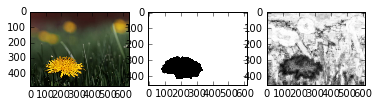

In [20]:
show_result(y_pred,y_test2.values,(size[0]-4,size[1]-4),target_name)

In [ ]:
%matplotlib qt